# Benchmark SF Energy Load dataset on multiple models

This tutorial shows how to create a simple benchmark with **multiple models** for the **SF Energy Load** datasets.
Further, it investigates on the individual performance of the NeuralProphet model configurations.

#### Imports

In [1]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    # enable custom widget manager for colab to display plotly plots
    from google.colab import output
    output.enable_custom_widget_manager()

In [2]:
import pandas as pd

from tot.datasets.dataset import Dataset
from tot.models.models_simple import LinearRegressionModel, ProphetModel
from tot.models.models_neuralprophet import NeuralProphetModel, TorchProphetModel
from tot.models.models_naive import SeasonalNaiveModel, NaiveModel
from tot.benchmark import SimpleBenchmark
from tot.plot_forecast_plotly import plot

from neuralprophet import set_log_level

# from plotly_resampler import register_plotly_resampler

ModuleNotFoundError: No module named 'tot.dataset'

In [6]:
set_log_level("ERROR")

#### Plot settings
We use ``plotly`` for standard plotting and activate the plotly-resampler package to seamlessly
display plots with large data.

In [15]:
pd.options.plotting.backend = 'plotly'
# register_plotly_resampler('auto')

## 1. Manage data
##### Load datasets
We load the **SF Energy Load** datasets that we will use in the benchmark.

In [9]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_sf_load= pd.read_csv(data_location + "energy/SF_hospital_load.csv")

##### Inspect dataset
First, let´s have a closer look at the datasets. The **SF Energy Load** dataset has a single time
series with 8760 samples. It has hourly frequency, and a daily and weekly seasonality. It does not seem to have a clear
trend.

data samples: 8760


<AxesSubplot: xlabel='ds'>

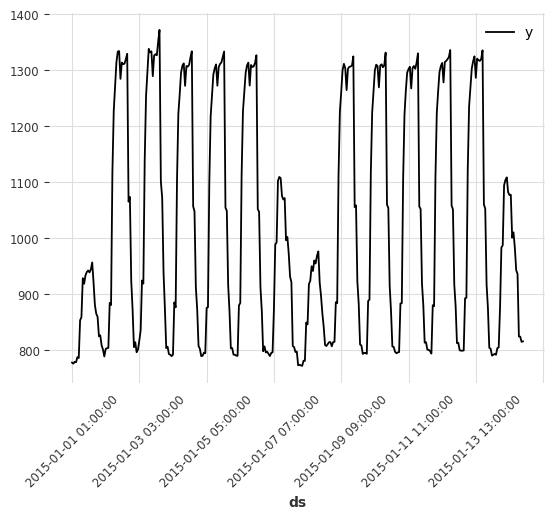

In [17]:
print('data samples:', df_sf_load.shape[0])
df_sf_load[0:14*24].plot(x='ds', y='y')

## 2. Set up the simple benchmark with 6 models
We offer a template for a simple benchmark that is filled with the selected dataset(s), model(s) and model parameters.

First, we input the ``df_sf_load``, the name, and the data's frequency to the ``dataset_list``.
Ideally, we add all available information about the dataset, in this the hourly frequency ``freq="H"``.

In [20]:
dataset_list = [
    Dataset(df=df_sf_load, name="sf_load", freq="H"),
]

##### Configure common model hyperparameters
We want to compare the selected models on the same prediction task. We define N_FORECAST = 3 for all models. Besides for
Prophet and TorchProphet, which only offers 1-step predictions.
For all NeuralProphet models (which includes TorchProphet) we set a common ``learning_rate`` and ``epochs``.

In [21]:
N_FORECASTS = 3
LR = 0.01
EPOCHS = 20

##### Select models and individual model parameters
In total, we compare 6 different models. For each model we define the relevant hyperparameters. The NeuralProphet model
we compare among 3 different configurations. The most simple configuration of NeuralProphet has **no autoregression**
enabled.
The 2nd configuration has **autoregression** enabled. For the 3rd configuration we add a pre-defined number of
**hidden layers**. For the Prophet model we implement the original version as well as the offered neuralprophet
wrapper, i.e. TorchProphet.
To ensure comparability, we set the same number of lags ``n_lags`` for all models hat rely on historic data.

In [22]:
model_classes_and_params = [
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 24,
                          "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False,
                          "num_hidden_layers": 1, "d_hidden": 64,
                          "n_changepoints":0, "growth":'linear',
                          "learning_rate": LR, "epochs": EPOCHS }),
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 24,
                          "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False,
                           "n_changepoints":0, "growth":'linear',
                          "learning_rate": LR, "epochs": EPOCHS}),
    (NeuralProphetModel, {"n_forecasts": 1,
                          "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False,
                          "n_changepoints":0, "growth":'linear',
                          "learning_rate": LR, "epochs": EPOCHS}),
    (ProphetModel, {"daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False }),
    (TorchProphetModel, {'interval_width': 0,
                         "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False}),
    (SeasonalNaiveModel, {"n_forecasts": N_FORECASTS, "season_length": 24}),
    (NaiveModel, {"n_forecasts": N_FORECASTS}),
    (LinearRegressionModel, {"n_forecasts": N_FORECASTS, "lags": 24, "output_chunk_length": N_FORECASTS}),
]

#### Configure the benchmark
Now, we add the dataset and the configured models to the SimpleBenchmark template to instantiate a benchmark. We select
to return the MAPE error metric.
Further error metrics can be added on demand. Further, we select the test data to be 40%.

In [23]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params,
    datasets=dataset_list,
    metrics=["MAPE"],
    test_percentage=0.4,
)

Besides the SimpleBenchmark class we offer further templates for pre-configured benchmarks as well as the option to
manually configure a benchmark. For details, check the BenchmarkingTemplates.ipynb tutorial. We further offer various
error metrics.

#### Run the benchmark
We simply execute the benchmark by calling benchmark.run() and print the train and test results.
To ensure reproducible results a seed is set within the procedure.


In [34]:
results_train, results_test = benchmark.run()

In [25]:
results_test

,data,model,params,experiment,MAPE
0,sf_load,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 24, 'daily_season...",sf_load_NeuralProphet_n_forecasts_3_n_lags_24_...,2.326252
1,sf_load,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 24, 'daily_season...",sf_load_NeuralProphet_n_forecasts_3_n_lags_24_...,3.945043
2,sf_load,NeuralProphet,"{'n_forecasts': 1, 'daily_seasonality': True, ...",sf_load_NeuralProphet_n_forecasts_1_daily_seas...,7.201104
3,sf_load,Prophet,"{'daily_seasonality': True, 'weekly_seasonalit...",sf_load_Prophet_daily_seasonality_True_weekly_...,7.358816
4,sf_load,TorchProphet,"{'interval_width': 0, 'daily_seasonality': Tru...",sf_load_TorchProphet_interval_width_0_daily_se...,7.647678
5,sf_load,SeasonalNaive,"{'n_forecasts': 3, 'season_length': 24, '_data...",sf_load_SeasonalNaive_n_forecasts_3_season_len...,7.058735
6,sf_load,NaiveModel,"{'n_forecasts': 3, '_data_params': {'freq': 'H'}}",sf_load_NaiveModel_n_forecasts_3__data_params_...,7.079551
7,sf_load,LinearRegressionModel,"{'n_forecasts': 3, 'lags': 24, 'output_chunk_l...",sf_load_LinearRegressionModel_n_forecasts_3_la...,3.696180


## 3. Let`s have a look at the individual results
We plot and compare the forecasts of the test data of the NeuralProphet configurations.
Since the **SF Energy Load** data has no clear trend, all configurations have  ``n_changpoints=0`` and ``growth='linear'``
to predict one linear trend over the full train data range. Additionally, the ``daily_seasonality=True`` and
``weekly_seasonality=True`` was set for all configurations.

#### NeuralProphet Configuration 1

The NeuralProphet configuration 1  has not autoregression enabled and therefore ``n_forecast=1`` was set.
To plot the results, we call the ``plot()`` function on the forecast. We can look up the experiment index of the
respective forecast in the result table.

In [26]:
print('MAPE',benchmark.df_metrics_test.loc[2,'MAPE'])

MAPE 7.201103687286377


In [28]:
fcst_config1 = benchmark.fcst_test[2]
fig = plot(fcst_config1[-14*24:])
fig

#### NeuralProphet Configuration 2
For NeuralProphet configuration 2 autoregression with ``n_lags=24`` was added which is equal to 24h.

In [29]:
print('MAPE',benchmark.df_metrics_test.loc[1,'MAPE'])

MAPE 3.9450433254241943


In [31]:
fcst_config2 = benchmark.fcst_test[1]
fig = plot(fcst_config2[-14*24:])
fig

#### NeuralProphet Configuration 3
For NeuralProphet configuration 3 one hidden layer ``num_hidden_layers=1`` with ``d_hidden=64`` was added.

In [32]:
print('MAPE',benchmark.df_metrics_test.loc[0,'MAPE'])

MAPE 2.326251983642578


In [33]:
fcst_config3 = benchmark.fcst_test[0]
fig = plot(fcst_config3[-14*24:])
fig

#### Result discussion
Comparing all models, the **NeuralProphet configuration 3** achieves the
best results on the SF Energy Load data. The **NeuralProphet configuration 2** shows a performance close
to that. Hence, we can conclude that autoregression is essential to perform well on predicting the
future data. Adding a hidden layer to the model benefits the performance further. The individual
shapes of the data are predicted better in this case.
Models without autoregressive capabilities perform comparatively worse. Except the performance of
the **LinearRegression** is close to the models with autoregressive capabilities.
